<a href="https://colab.research.google.com/github/easyymm/TIL/blob/main/Titanic_%EC%A0%84%EC%B2%98%EB%A6%AC%2B%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Titanic 생존자 예측**
https://www.kaggle.com/c/titanic/data

Goal: "어떤 특징을 가진 사람이 생존할 가능성이 높은가?"를 예측하는 모델 만들기

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/data/MyDrive/titanic/titanic/asset/train.csv')
test = pd.read_csv('/content/data/MyDrive/titanic/titanic/asset/test.csv')

# 결측치 처리

## Cabin 컬럼 제거

In [ ]:
train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

## Age 컬럼 결측치: 새 피처 Title(<-Name)별 중앙값

In [ ]:
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
# 같은 의미의 타이틀 매핑

title_mapping = {
    'Miss': 'Woman', 'Mrs':'Woman', 'Mlle': 'Woman', 'Ms': 'Woman', 'Mme': 'Woman', 'Lady': 'Woman', 'Countess': 'Woman',
    'Sir': 'Mr', 'Don': 'Mr', 'Jonkheer': 'Mr',
    'Col': 'prof', 'Major': 'prof', 'Capt': 'prof',
    'Rev': 'prof', 'Dr': 'prof'
    }
train['Title'] = train['Title'].replace(title_mapping)
test['Title'] = test['Title'].replace(title_mapping)

In [ ]:
valid_titles = set(train['Title'].unique())

train['Title'] = train['Title'].apply(lambda x: x if x in valid_titles else 'Other')
test['Title'] = test['Title'].apply(lambda x: x if x in valid_titles else 'Other')

In [ ]:
# 타이틀별로 나이 결측치 중앙값으로 보간
train['Age'] = train.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

## Embarked 결측치 처리
범주형 변수, mode로 보간  
(수가 적어 단순 제거도 가능)

In [ ]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

## Fare 결측치 처리

In [ ]:
# 결측치를 해당 등급의 평균값으로 보간
test['Fare'] = test.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))

# 이상치 처리: Fare(IQR)

In [ ]:
Q1 = train["Fare"].quantile(0.25)
Q3 = train["Fare"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# train 이상치 제거
train = train[(train['Fare'] >= Q1 - 1.5 * IQR) & (train['Fare'] <= Q3 + 1.5 * IQR)]

# test 이상치 변환
test["Fare"] = np.clip(test["Fare"], lower_bound, upper_bound)

# 왜도 처리: Box-Cox 변환

In [ ]:
from scipy import stats

train['Fare'], best_lambda = stats.boxcox(train['Fare'] + 1)
test['Fare'], best_lambda = stats.boxcox(test['Fare'] + 1)

In [ ]:
from scipy.stats import skew

print(skew(train['Fare']))
print(skew(test['Fare']))

0.03321048442702723
0.0007588912563873815


# 범주형 변수 인코딩

#### Label Encoding: Pclass, Sex

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_pclass = LabelEncoder()
train['Pclass'] = le_pclass.fit_transform(train['Pclass'])
test['Pclass'] = le_pclass.transform(test['Pclass'])

le_sex = LabelEncoder()
train['Sex'] = le_sex.fit_transform(train['Sex'])
test['Sex'] = le_sex.transform(test['Sex'])

#### One-Hot Encoding: Embarked, Title

In [ ]:
train = pd.get_dummies(train, columns=['Embarked', 'Title'], drop_first=False)
test = pd.get_dummies(test, columns=['Embarked', 'Title'], drop_first=False)

train = train.drop(columns=['Embarked_C', 'Title_Mr'])
test = test.drop(columns=['Embarked_C', 'Title_Mr'])

In [ ]:
# Family: 가족 구성원 수=형제/자매/배우자+부모/자녀+본인
train['Family'] = train['SibSp'] + train['Parch'] + 1
test['Family'] = test['SibSp'] + test['Parch'] + 1

# Group: 티켓 번호 기반 일행 수 계산(본인 포함)
train['Group'] = train.groupby('Ticket')['Ticket'].transform('count')
test['Group'] = test.groupby('Ticket')['Ticket'].transform('count')

# Total Group: Group, Family 중 max값
train['Total_Group'] = train[['Group', 'Family']].max(axis=1)
test['Total_Group'] = test[['Group', 'Family']].max(axis=1)

### 다중공선성 확인(VIF)
- VIF: Variance Inflation Factor.  
- VIF 값이 높으면, 해당 변수와 다른 변수 간 강한 상관관계가 있음=다중공선성 문제가 있음.  
- 일반적으로 VIF>5면 주의를 요하며 VIF>10이면 다중공선성 문제가 있다고 판단한다.

#### 파생변수 미포함 VIF

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_vars = ['Pclass', 'Age', 'Fare', 'Sex', 'SibSp', 'Parch']
dummy_vars = ['Embarked_Q', 'Embarked_S']

In [ ]:
X_numeric = train[numeric_vars]
X_categorical = train[dummy_vars]
X = pd.concat([X_numeric, X_categorical], axis=1)

X = sm.add_constant(X)

X = X.astype(float)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     Variable        VIF
0       const  62.299469
1      Pclass   1.959940
2         Age   1.325863
3        Fare   2.264478
4         Sex   1.138296
5       SibSp   1.625697
6       Parch   1.462771
7  Embarked_Q   1.612870
8  Embarked_S   1.531728


#### 파생변수 포함 VIF

In [ ]:
numeric_vars1 = ['Pclass', 'Age', 'Fare', 'Total_Group']
dummy_vars1 = ['Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Woman', 'Title_prof']

In [ ]:
X_numeric = train[numeric_vars1]
X_categorical = train[dummy_vars1]
X = pd.concat([X_numeric, X_categorical], axis=1)

X = sm.add_constant(X)

X = X.astype(float)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       Variable        VIF
0         const  59.218580
1        Pclass   2.098254
2           Age   1.529449
3          Fare   2.448665
4   Total_Group   2.073662
5    Embarked_Q   1.606859
6    Embarked_S   1.536275
7  Title_Master   1.510591
8   Title_Woman   1.226504
9    Title_prof   1.058518


성별과 타이틀이 거의 같은 정보를 담고 있으므로, 성별도 드랍한다.

### 피처 제거
사용하지 않을 피처는 제거한다.

In [ ]:
train = train.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Family', 'Group'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Family', 'Group'], axis=1)

In [ ]:
print(train.columns)
print(test.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Woman', 'Title_prof', 'Total_Group'],
      dtype='object')
Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Other', 'Title_Woman', 'Title_prof',
       'Total_Group'],
      dtype='object')


# 스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[['Age', 'Fare']] = scaler.fit_transform(train[['Age', 'Fare']])
test[['Age', 'Fare']] = scaler.transform(test[['Age', 'Fare']])

스케일링의 경우에도 test 데이터를 fit 해서는 안됨 > train 데이터에 대해서만 fit 이후에 train 과 test set에 대해 transform
머신러닝 딥러닝 모델이 학습을 하는 과정에서 어떠한 방식으로든 test set 데이터를 사용하게 되어서는 안됩니다.

[방법]

1. train / test(valid) split 먼저 수행
2. train에 대해서 scaling 방법 학습
3. scaling한 train 데이터를 이용하여 모델 학습
4. train 데이터로 학습한 scaling 방법을 이용하여 test(valid) 데이터 scaling
5. scaling한 test(valid) 데이터를 이용하여 모델 학습

[참고](https://www.kaggle.com/code/hiejpaul/c-team-1#5.-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81(Data-Scaling))

# 모델링

## 교차검증
교차검증을 하는 이유: 과적합을 피하기 위함.

- 과대적합이란?: 학습 데이터에 과하게 적합한 상태여서 다른 데이터에서는 정확한 예측이 불가한 상태.
- 과소적합이란?: 데이터가 부족하거나 데이터의 특성 자체가 너무 단순해서 기계가 제대로 학습이 되지 않은 상태.
---
- K-Fold: 집합을 체계적으로 바꿔가면서 모든 데이터에 대한 모델의 성과를 검증하는 방식.
- Stratified K-Fold: 불균형한 데이터셋을 위한 K-Fold 방법.

타이타닉 데이터셋은 Survived=1과 0의 비율이 불균형하므로, Stratified K-Fold가 더 적합할 것이다.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

selected_features = ['Pclass', 'Age', 'Fare', 'Total_Group', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Woman', 'Title_prof']

X = train[selected_features]
y = train['Survived']

In [ ]:
# Stratified K-Fold
rf = RandomForestClassifier(random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf, X, y, cv=skf, scoring='accuracy')

print("Stratified K-Fold 교차검증 점수: ", cv_scores)
print("Stratified K-Fold 평균 교차검증 점수: ", cv_scores.mean())

Stratified K-Fold 교차검증 점수:  [0.78709677 0.80645161 0.83225806 0.8        0.81935484]
Stratified K-Fold 평균 교차검증 점수:  0.8090322580645161


In [ ]:
# K-Fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf, X, y, cv=kf, scoring='accuracy')

print("K-Fold 교차검증 점수: ", cv_scores)
print("K-Fold 평균 교차검증 점수: ", cv_scores.mean())

K-Fold 교차검증 점수:  [0.77419355 0.78709677 0.82580645 0.8516129  0.80645161]
K-Fold 평균 교차검증 점수:  0.8090322580645161


## 모델 평가 지표

<회귀모델 평가 지표>
- MAE (평균 절대 오차) : 정답값과 예측값의 차이를 절댓값으로 변환한 뒤 합산해 평균을 구함. 특이값이 많은 경우에 주로 사용됨. 값이 낮을수록 좋음.
- MSE (평균 제곱 오차) : 정답값과 예측값의 차이를 제곱한 뒤 평균을 구함. 가장 일반적/직관적. 값이 낮을수록 좋음.
- RMSE (평균 제곱근 오차) : MSE에 루트를 씌운 값. 값이 낮을수록 좋음.
- MAPE (평균 절대 비율 오차) : MAE를 비율, 퍼센트로 표현하여 스케일 의존적 문제를 개선.
- MPE (평균 백분율 오차) : MAPE에서 절댓값을 제외한 지표.

<분류모델 평가 지표>
- 정확도(Accuracy) : 전체 데이터 중에 정확하게 예측한 데이터의 수. 불균형한 데이터의 경우에는 적합하지 않음.
- 오차 행렬(Confusion Matrix) : 분류의 예측 범주와 실제 데이터의 분류 범주를 교차 표 형태로 정리한 행렬.
- 정밀도(Precision) : 분류 모델이 positive로 판정한 것 중, 실제로 positive인 샘플의 비율. positive로 검출된 결과가 얼마나 정확한지 나타냄.
- 재현율(Recall) : 실제 positive 샘플 중 분류 모델이 positive로 판정한 비율. 분류 모델이 실제 positive 클래스를 얼마나 빠지지 않고 잘 잡아내는지 측정함.
- F1-score : 분류 모델의 Precision과 Recall 성능을 동시에 고려해 종합적 평가를 하기 위해해 사용하는 지표로, Precision과 Recall의 조화평균.
- AUC - ROC : 실제 Negative label인 경우 중 모델이 positive로 예측한 비율.
- Precision-recall curve : x축을 recall, y축을 precision으로 하는 커브.


## 모델 선택

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

selected_features = ['Pclass', 'Age', 'Fare', 'Total_Group', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Woman', 'Title_prof']

X = train[selected_features]
y = train['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

### SL(지도학습)-분류


#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_valid)
print("Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Logistic Regression Accuracy: 0.7982832618025751
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       151
           1       0.74      0.66      0.70        82

    accuracy                           0.80       233
   macro avg       0.78      0.77      0.77       233
weighted avg       0.79      0.80      0.80       233



#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_valid)
print("KNN Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

KNN Accuracy: 0.7639484978540773
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       151
           1       0.68      0.62      0.65        82

    accuracy                           0.76       233
   macro avg       0.74      0.73      0.74       233
weighted avg       0.76      0.76      0.76       233



#### SVC

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', probability=True, random_state=42)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_valid)
print("SVC Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

SVC Accuracy: 0.7982832618025751
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       151
           1       0.75      0.65      0.69        82

    accuracy                           0.80       233
   macro avg       0.78      0.76      0.77       233
weighted avg       0.79      0.80      0.79       233



#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_valid)
print("Decision Tree Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Decision Tree Accuracy: 0.759656652360515
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       151
           1       0.65      0.67      0.66        82

    accuracy                           0.76       233
   macro avg       0.74      0.74      0.74       233
weighted avg       0.76      0.76      0.76       233



### 앙상블

#### 스태킹: Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# rf, gbm 스태킹함
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gbm', GradientBoostingClassifier(n_estimators=100, random_state=42))
]
final_model = LogisticRegression(max_iter=1000, random_state=42)

st = StackingClassifier(estimators=base_models, final_estimator=final_model)
st.fit(X_train, y_train)

y_pred = st.predict(X_valid)
print("Stacking Classifier Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Stacking Classifier Accuracy: 0.8240343347639485
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       151
           1       0.82      0.65      0.72        82

    accuracy                           0.82       233
   macro avg       0.82      0.78      0.80       233
weighted avg       0.82      0.82      0.82       233



#### 배깅: RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)
print("Random Forest Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Random Forest Accuracy: 0.7939914163090128
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       151
           1       0.74      0.63      0.68        82

    accuracy                           0.79       233
   macro avg       0.78      0.76      0.77       233
weighted avg       0.79      0.79      0.79       233



#### 부스팅

##### GBM

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_valid)
print("GBM Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

GBM Accuracy: 0.8154506437768241
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       151
           1       0.77      0.67      0.72        82

    accuracy                           0.82       233
   macro avg       0.80      0.78      0.79       233
weighted avg       0.81      0.82      0.81       233



##### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_valid)
print("XGBoost Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

XGBoost Accuracy: 0.8454935622317596
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       151
           1       0.85      0.68      0.76        82

    accuracy                           0.85       233
   macro avg       0.85      0.81      0.82       233
weighted avg       0.85      0.85      0.84       233



##### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_valid)
print("LightGBM Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

[LightGBM] [Info] Number of positive: 181, number of negative: 361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 542, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333948 -> initscore=-0.690381
[LightGBM] [Info] Start training from score -0.690381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


##### CatBoost

In [ ]:
pip install CatBoost

In [ ]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
cat.fit(X_train, y_train)

y_pred = cat.predict(X_valid)
print("CatBoost Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

CatBoost Accuracy: 0.8111587982832618
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       151
           1       0.76      0.67      0.71        82

    accuracy                           0.81       233
   macro avg       0.80      0.78      0.79       233
weighted avg       0.81      0.81      0.81       233



##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_valid)
print("AdaBoost Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

AdaBoost Accuracy: 0.8111587982832618
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       151
           1       0.76      0.67      0.71        82

    accuracy                           0.81       233
   macro avg       0.80      0.78      0.79       233
weighted avg       0.81      0.81      0.81       233



## 과적합 방지: 정규화(Regulation)
- L1 정규화(Lasso): 설명력에 기여하지 못하는 독립변수의 회귀계수를 0으로 만듦
- L2 정규화(Ridge): 모델의 설명력에 기여하지 못하는 독립변수의 회귀계수 크기를 0에 근접하도록 축소
- 엘라스틱 넷(Elastic Net): 릿지와 라쏘의 결합. 즉 L1-norm 과 L2-norm을 모두 이용하여 패널티를 부과하여 회귀모델을 생성.

In [ ]:
from sklearn.linear_model import RidgeClassifier, Lasso

### L1 정규화(Lasso)

In [ ]:
# L1 정규화 적용 (Lasso)
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_valid)
print("L1-Regularized Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

L1-Regularized Logistic Regression Accuracy: 0.7982832618025751
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       151
           1       0.74      0.66      0.70        82

    accuracy                           0.80       233
   macro avg       0.78      0.77      0.77       233
weighted avg       0.79      0.80      0.80       233



### L2 정규화(Ridge)

In [ ]:
# L2 정규화 적용 (Ridge)
ridge = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, random_state=42)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_valid)
print("L2-Regularized Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

L2-Regularized Logistic Regression Accuracy: 0.8025751072961373
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       151
           1       0.75      0.66      0.70        82

    accuracy                           0.80       233
   macro avg       0.79      0.77      0.78       233
weighted avg       0.80      0.80      0.80       233



### Elastic Net(L1+L2)

In [ ]:
# Elastic Net (L1 + L2 정규화) 적용
en = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42)
en.fit(X_train, y_train)

y_pred = en.predict(X_valid)
print("Elastic Net Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Elastic Net Logistic Regression Accuracy: 0.7939914163090128
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       151
           1       0.73      0.66      0.69        82

    accuracy                           0.79       233
   macro avg       0.78      0.76      0.77       233
weighted avg       0.79      0.79      0.79       233



## 모델 성능 개선

In [ ]:
# 캐글 타이타닉 평가지표: Accuracy
print('모델별 Accuracy 비교')
print("lr: ", accuracy_score(y_valid, lr.predict(X_valid)))
print("knn: ", accuracy_score(y_valid, knn.predict(X_valid)))
print("svc: ", accuracy_score(y_valid, svc.predict(X_valid)))
print("dt: ", accuracy_score(y_valid, dt.predict(X_valid)))
print("st: ", accuracy_score(y_valid, st.predict(X_valid)))
print("rf: ", accuracy_score(y_valid, rf.predict(X_valid)))
print("gbm: ", accuracy_score(y_valid, gbm.predict(X_valid)))
print("xgb: ", accuracy_score(y_valid, xgb.predict(X_valid)))
print("lgbm: ", accuracy_score(y_valid, lgbm.predict(X_valid)))
print("cat: ", accuracy_score(y_valid, cat.predict(X_valid)))
print("ada: ", accuracy_score(y_valid, ada.predict(X_valid)))
print("ridge", accuracy_score(y_valid, ridge.predict(X_valid)))
print("lasso", accuracy_score(y_valid, lasso.predict(X_valid)))
print("en", accuracy_score(y_valid, en.predict(X_valid)))

모델별 Accuracy 비교
lr:  0.7982832618025751
knn:  0.7639484978540773
svc:  0.7982832618025751
dt:  0.759656652360515
st:  0.8240343347639485
rf:  0.7939914163090128
gbm:  0.8154506437768241
xgb:  0.8454935622317596
lgbm:  0.8283261802575107
cat:  0.8111587982832618
ada:  0.8111587982832618
ridge 0.8025751072961373
lasso 0.7982832618025751
en 0.7939914163090128


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'XGBoost'),
  Text(1, 0, 'LightGBM'),
  Text(2, 0, 'Stacking'),
  Text(3, 0, 'GBM'),
  Text(4, 0, 'CatBoost'),
  Text(5, 0, 'AdaBoost'),
  Text(6, 0, 'Ridge (L2)'),
  Text(7, 0, 'Logistic Regression'),
  Text(8, 0, 'SVC'),
  Text(9, 0, 'Lasso (L1)'),
  Text(10, 0, 'Random Forest'),
  Text(11, 0, 'Elastic Net'),
  Text(12, 0, 'KNN'),
  Text(13, 0, 'Decision Tree')])

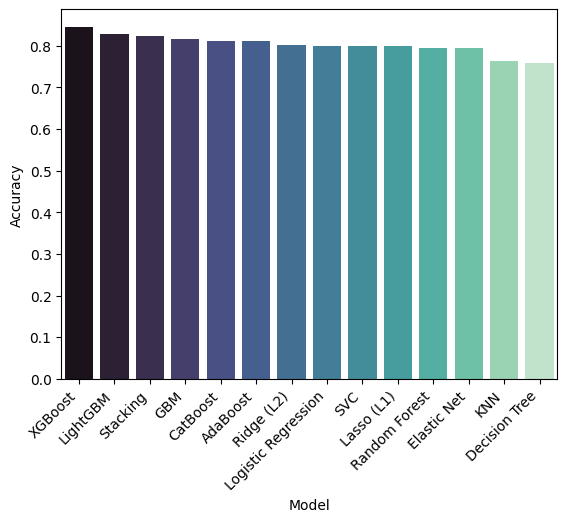

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델별 Accuracy를 저장할 딕셔너리 생성
accuracy_results = {
    "Logistic Regression": accuracy_score(y_valid, lr.predict(X_valid)),
    "KNN": accuracy_score(y_valid, knn.predict(X_valid)),
    "SVC": accuracy_score(y_valid, svc.predict(X_valid)),
    "Decision Tree": accuracy_score(y_valid, dt.predict(X_valid)),
    "Stacking": accuracy_score(y_valid, st.predict(X_valid)),
    "Random Forest": accuracy_score(y_valid, rf.predict(X_valid)),
    "GBM": accuracy_score(y_valid, gbm.predict(X_valid)),
    "XGBoost": accuracy_score(y_valid, xgb.predict(X_valid)),
    "LightGBM": accuracy_score(y_valid, lgbm.predict(X_valid)),
    "CatBoost": accuracy_score(y_valid, cat.predict(X_valid)),
    "AdaBoost": accuracy_score(y_valid, ada.predict(X_valid)),
    "Lasso (L1)": accuracy_score(y_valid, lasso.predict(X_valid)),
    "Ridge (L2)": accuracy_score(y_valid, ridge.predict(X_valid)),
    "Elastic Net": accuracy_score(y_valid, en.predict(X_valid))
}

accuracy_df = pd.DataFrame(accuracy_results.items(), columns=["Model", "Accuracy"])
accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False)

sns.barplot(data=accuracy_df, x="Model", y="Accuracy", palette="mako")
plt.xticks(rotation=45, ha="right")

### GBM 교차검증
Stratified K-Fold, k=5

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(gbm_model, X, y, cv=kf, scoring='accuracy')

print(cv_scores)
print(cv_scores.mean())

[0.8        0.8        0.80645161 0.80645161 0.84516129]
0.8116129032258066


In [ ]:
X.columns

Index(['Pclass', 'Age', 'Fare', 'Total_Group', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Woman', 'Title_prof'],
      dtype='object')

### 하이퍼파라미터 튜닝

#### Grid Search
- 가능한 모든 조합의 하이퍼파라미터로 훈련시켜서 최적의 조합을 찾음.
- 범위를 지정해주어야 함.
- 모든 하이퍼파라미터 후보들에 대한 일반화 성능을 확인하기 때문에 시간이 오래 걸림.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 학습률
    'n_estimators': [100, 200, 300, 400],  # 트리 개수
    'max_depth': [3, 5, 7]  # 트리 깊이
}
# 하이퍼파라미터가 너무 많으면 최적 조합 찾는 데 오래 걸림, 중요한 파라미터만 설정.
# 목적에 따라 파라미터 추가 가능

gbm = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 교차 검증 정확도:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
최적 하이퍼파라미터: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400}
최고 교차 검증 정확도: 0.846774193548387


In [ ]:
# 최적 하이퍼파라미터 적용해 다시 학습하기
best_gbm_grid = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)
best_gbm_grid.fit(X_train, y_train)

y_pred = best_gbm_grid.predict(X_valid)
print("Grid Search-GBM accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Grid Search-GBM accuracy: 0.8193548387096774
              precision    recall  f1-score   support

           0       0.81      0.93      0.86        95
           1       0.85      0.65      0.74        60

    accuracy                           0.82       155
   macro avg       0.83      0.79      0.80       155
weighted avg       0.82      0.82      0.81       155



#### Random Search
- 경계 내에서 임의의 조합을 추출하여 최적의 조합을 찾는 방법, 빠름.
- 특히 적은 수의 하이퍼파라미터가 모델 성능의 영향을 미치는 경우에 좋은 결과를 낸다.
- GridSearch에 비해 시간은 적게 걸리지만, 말 그대로 "랜덤"하게 몇 개만 뽑아서 확인해보는 식이라 정확도가 다소 떨어질 수 있음.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(3, 10, 2)
}

gbm = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=gbm, param_distributions=param_dist,
                                   n_iter=30, cv=5, scoring='accuracy',
                                   n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", random_search.best_params_)
print("최고 교차 검증 정확도:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
최적 하이퍼파라미터: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.03111111111111111}
최고 교차 검증 정확도: 0.8435483870967742


In [ ]:
# 최적 하이퍼파라미터 적용해 다시 학습하기
best_gbm_random = GradientBoostingClassifier(**random_search.best_params_, random_state=42)
best_gbm_random.fit(X_train, y_train)

y_pred = best_gbm_random.predict(X_valid)
print("Random Search-GBM accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Random Search-GBM accuracy: 0.8
              precision    recall  f1-score   support

           0       0.80      0.89      0.85        95
           1       0.80      0.65      0.72        60

    accuracy                           0.80       155
   macro avg       0.80      0.77      0.78       155
weighted avg       0.80      0.80      0.80       155



#### Bayesian Optimization
- 목적함수와 하이퍼파라미터의 조합을 대상으로 Surrogate model을 만들어 평가하고 Acquisition Function이 다음 인풋으로 사용할 조합을 추천하는 과정을 반복하면서 순차적으로 업데이트하여 최적의 조합을 찾아낸다.
- 사전 정보를 최적값 탐색에 반영.

In [ ]:
pip install optuna

In [ ]:
import optuna # Optuna 라이브러리 사용해 베이지안 최적화 사용하기
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)

    gbm = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    score = cross_val_score(gbm, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("최적 하이퍼파라미터:", study.best_params)
print("최고 교차 검증 정확도:", study.best_value)

[I 2025-03-02 06:02:45,642] A new study created in memory with name: no-name-3fe02bf6-f0b1-4953-b311-4efc8fcb6854
[I 2025-03-02 06:02:47,364] Trial 0 finished with value: 0.835483870967742 and parameters: {'learning_rate': 0.03171234040744999, 'n_estimators': 289, 'max_depth': 3}. Best is trial 0 with value: 0.835483870967742.
[I 2025-03-02 06:03:05,797] Trial 1 finished with value: 0.8032258064516128 and parameters: {'learning_rate': 0.08420345030609709, 'n_estimators': 293, 'max_depth': 10}. Best is trial 0 with value: 0.835483870967742.
[I 2025-03-02 06:03:23,093] Trial 2 finished with value: 0.8048387096774194 and parameters: {'learning_rate': 0.040954905480423076, 'n_estimators': 329, 'max_depth': 9}. Best is trial 0 with value: 0.835483870967742.
[I 2025-03-02 06:03:32,015] Trial 3 finished with value: 0.835483870967742 and parameters: {'learning_rate': 0.010905858810141899, 'n_estimators': 420, 'max_depth': 6}. Best is trial 0 with value: 0.835483870967742.
[I 2025-03-02 06:03:3

최적 하이퍼파라미터: {'learning_rate': 0.015667388522149786, 'n_estimators': 398, 'max_depth': 5}
최고 교차 검증 정확도: 0.853225806451613


In [ ]:
best_gbm_bay = GradientBoostingClassifier(**study.best_params, random_state=42)

best_gbm_bay.fit(X_train, y_train)

y_pred = best_gbm_bay.predict(X_valid)
print("Bayesian-GBM accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Bayesian-GBM accuracy: 0.8129032258064516
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        95
           1       0.82      0.67      0.73        60

    accuracy                           0.81       155
   macro avg       0.81      0.79      0.79       155
weighted avg       0.81      0.81      0.81       155



# Test 예측

## GBM
- 분할 비율 8:2
- Public Score: 0.75119

In [ ]:
X_test = test[X_train.columns]
y_test_pred = best_gbm_grid.predict(X_test)

# 기존 submission 파일 수정하여 저장
submission_path = "/content/data/MyDrive/titanic/titanic/asset/result/submission.csv"
submit = pd.read_csv(submission_path)

submit["Survived"] = y_test_pred

# 수정된 파일을 다시 저장
submit.to_csv(submission_path, index=False)

In [ ]:
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [ ]:
submit['Survived'].value_counts()

,count
Survived,
0,330
1,88


## XGBoost
- 분할 비율 7:3
- Public Score: 0.76794

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 교차 검증 정확도:", grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
최적 하이퍼파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
최고 교차 검증 정확도: 0.8580190282025144


In [ ]:
best_xgb_grid = XGBClassifier(**grid_search.best_params_, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_grid.fit(X_train, y_train)

y_pred = best_xgb_grid.predict(X_valid)
print("Grid Search-XGBoost Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Grid Search-XGBoost Accuracy: 0.8369098712446352
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       151
           1       0.87      0.63      0.73        82

    accuracy                           0.84       233
   macro avg       0.85      0.79      0.81       233
weighted avg       0.84      0.84      0.83       233



In [ ]:
X_test = test[X_train.columns]
y_test_pred_xgb = best_xgb_grid.predict(X_test)

submission_path_xgb = "/content/data/MyDrive/titanic/titanic/asset/result/submission_xgb.csv"
submit_xgb = pd.read_csv("/content/data/MyDrive/titanic/titanic/asset/result/submission.csv")

submit_xgb["Survived"] = y_test_pred_xgb

submit_xgb.to_csv(submission_path_xgb, index=False)

In [ ]:
submit_xgb['Survived'].value_counts()

,count
Survived,
0,281
1,137
